# 2. Pipeline Híbrido para Clasificación Biomédica

Este notebook implementa un pipeline híbrido que combina:
1. **Embeddings biomédicos** usando PubMedBERT/BioBERT
2. **NER biomédico** con scispaCy para extracción de entidades
3. **Enriquecimiento semántico** con diccionarios FDA/OMS/INVIMA
4. **Clasificación híbrida** con XGBoost/LightGBM

El objetivo es superar el baseline tradicional TF-IDF + Logistic Regression.

In [1]:
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Configurar el path del proyecto
notebook_dir = Path().absolute()
project_root = notebook_dir.parent

# Agregar src al path de Python
sys.path.append(str(project_root))

print(f"Project root: {project_root}")
print(f"Python path updated: {str(project_root) in sys.path}")

Project root: c:\Users\User\Desktop\Programacion\Python\Classification-App
Python path updated: True


In [2]:
# Importar librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('husl')
%matplotlib inline

print("✅ Librerías básicas importadas correctamente")

✅ Librerías básicas importadas correctamente


In [3]:
from collections import Counter

# Cargar los datos
DATA_PATH = project_root / "data" / "raw" / "challenge_data-18-ago.csv"

# Cargar dataset
print("Cargando dataset...")
df = pd.read_csv(DATA_PATH, sep=';')

# Convertir las etiquetas a listas
df['group'] = df['group'].apply(lambda x: x.split('|'))

print(f"✅ Dataset cargado: {df.shape}")
print(f"Columnas: {list(df.columns)}")
print(f"Total de documentos: {len(df)}")

# Mostrar distribución de clases
all_labels = [label for labels in df['group'] for label in labels]
label_counts = Counter(all_labels)

print("\nDistribución de clases:")
for label, count in label_counts.most_common():
    print(f"  {label}: {count} ({count/len(df)*100:.1f}%)")

# Verificar datos faltantes
print("\nDatos faltantes:")
print(f"  Títulos: {df['title'].isna().sum()}")
print(f"  Abstracts: {df['abstract'].isna().sum()}")

# Mostrar ejemplos
print("\nEjemplo de documento:")
print(f"Título: {df.iloc[0]['title']}")
print(f"Abstract: {df.iloc[0]['abstract'][:200]}...")
print(f"Etiquetas: {df.iloc[0]['group']}")

Cargando dataset...
✅ Dataset cargado: (3565, 3)
Columnas: ['title', 'abstract', 'group']
Total de documentos: 3565

Distribución de clases:
  neurological: 1785 (50.1%)
  cardiovascular: 1268 (35.6%)
  hepatorenal: 1091 (30.6%)
  oncological: 601 (16.9%)

Datos faltantes:
  Títulos: 0
  Abstracts: 0

Ejemplo de documento:
Título: Adrenoleukodystrophy: survey of 303 cases: biochemistry, diagnosis, and therapy.
Abstract: Adrenoleukodystrophy ( ALD ) is a genetically determined disorder associated with progressive central demyelination and adrenal cortical insufficiency . All affected persons show increased levels of s...
Etiquetas: ['neurological', 'hepatorenal']


## 🧩 **Paso 1: Probar Componentes Individuales**

Antes de crear el pipeline completo, vamos a probar cada componente por separado para entender su funcionamiento y verificar que todo esté funcionando correctamente.

🔬 TESTANDO EMBEDDINGS BIOMÉDICOS


INFO:src.features.biomedical_embeddings:Inicializando modelo: all-MiniLM-L6-v2
INFO:src.features.biomedical_embeddings:Dispositivo: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Intentando cargar sentence-transformers...


INFO:src.features.biomedical_embeddings:✅ Modelo sentence-transformers cargado exitosamente
INFO:src.features.biomedical_embeddings:Dimensión de embeddings: 384
INFO:src.features.biomedical_embeddings:Extrayendo embeddings de 20 textos...


✅ sentence-transformers cargado exitosamente

Probando con 20 documentos...


Batches: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
INFO:src.features.biomedical_embeddings:✅ Embeddings extraídos: (20, 384)


✅ Embeddings extraídos exitosamente!
   Forma: (20, 384)
   Dimensión: 384
   Tipo: float32

📊 Estadísticas de embeddings:
   mean_norm: 1.0
   std_norm: 3.998400899263288e-08
   mean_cosine_sim: 0.2290162891149521
   embedding_dim: 384.0000
   n_samples: 20.0000
   method: sentence-transformers

📈 Análisis visual de embeddings...


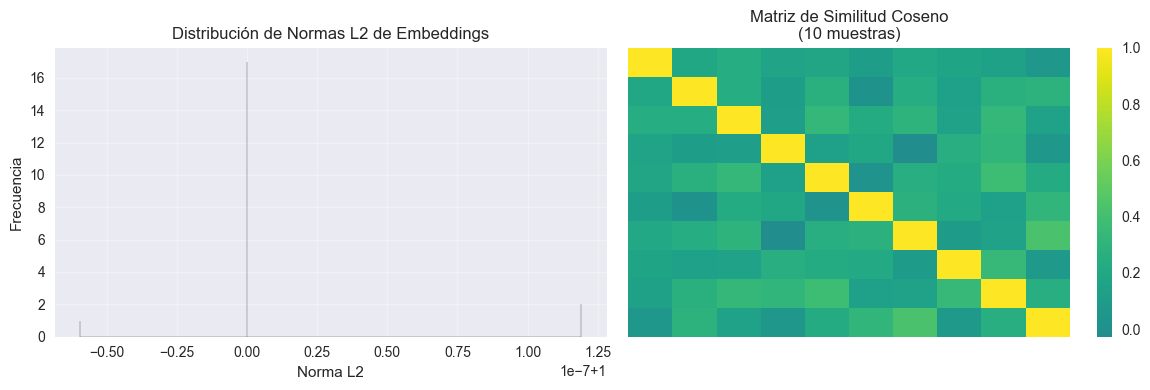

✅ Componente de embeddings funciona correctamente!
🔧 Método usado: sentence-transformers


In [4]:
# Implementación de fallback usando TF-IDF cuando sentence-transformers no está disponible
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# 🔬 Componente 1: Embeddings Biomédicos
print("=" * 60)
print("🔬 TESTANDO EMBEDDINGS BIOMÉDICOS")
print("=" * 60)

class SimpleBiomedicalEmbeddings:
    """Fallback para embeddings usando TF-IDF + SVD"""
    
    def __init__(self, embedding_dim=384):
        self.embedding_dim = embedding_dim
        self.tfidf = TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words='english',
            sublinear_tf=True
        )
        self.svd = TruncatedSVD(n_components=min(embedding_dim, 384), random_state=42)
        
    def combine_title_abstract(self, titles, abstracts):
        """Combina títulos y abstracts"""
        combined = []
        for title, abstract in zip(titles, abstracts):
            if pd.isna(abstract) or abstract.strip() == "":
                text = f"Title: {title}"
            else:
                text = f"Title: {title}. Abstract: {abstract}"
            combined.append(text)
        return combined
    
    def extract_from_dataframe(self, df, title_col='title', abstract_col='abstract', batch_size=32):
        """Extrae embeddings de un DataFrame"""
        titles = df[title_col].fillna("").tolist()
        abstracts = df[abstract_col].fillna("").tolist()
        
        combined_texts = self.combine_title_abstract(titles, abstracts)
        return self.extract_embeddings(combined_texts)
    
    def extract_embeddings(self, texts, batch_size=32, show_progress=True):
        """Extrae embeddings usando TF-IDF + SVD"""
        # Limpiar textos
        texts_clean = [text if text and not pd.isna(text) else "empty text" for text in texts]
        
        # TF-IDF
        tfidf_matrix = self.tfidf.fit_transform(texts_clean)
        
        # SVD para reducir dimensionalidad
        embeddings = self.svd.fit_transform(tfidf_matrix)
        
        # Normalizar L2
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        norms[norms == 0] = 1
        embeddings = embeddings / norms
        
        return embeddings.astype(np.float32)
    
    def get_embedding_stats(self, embeddings):
        """Calcula estadísticas"""
        return {
            'mean_norm': np.linalg.norm(embeddings, axis=1).mean(),
            'std_norm': np.linalg.norm(embeddings, axis=1).std(),
            'mean_cosine_sim': np.mean(np.dot(embeddings, embeddings.T)),
            'embedding_dim': embeddings.shape[1],
            'n_samples': embeddings.shape[0],
            'method': 'tfidf-svd'
        }

# Probar embeddings con fallback robusto
try:
    from src.features.biomedical_embeddings import BiomedicalEmbeddings, EmbeddingAnalyzer
    
    print("Intentando cargar sentence-transformers...")
    embeddings_extractor = BiomedicalEmbeddings(
        model_name="all-MiniLM-L6-v2",
        device="cpu"
    )
    
    # Verificar si realmente cargó sentence-transformers
    if hasattr(embeddings_extractor, 'use_sentence_transformers') and not embeddings_extractor.use_sentence_transformers:
        print("✅ Usando fallback TF-IDF integrado")
    else:
        print("✅ sentence-transformers cargado exitosamente")
    
except Exception as e:
    print(f"⚠️ Error con módulo principal: {e}")
    print("💡 Usando fallback simple TF-IDF...")
    embeddings_extractor = SimpleBiomedicalEmbeddings()

# Probar con muestra pequeña
sample_size = 20
df_sample = df.head(sample_size).copy()

print(f"\nProbando con {sample_size} documentos...")

try:
    # Extraer embeddings
    embeddings = embeddings_extractor.extract_from_dataframe(
        df_sample, 
        title_col='title', 
        abstract_col='abstract',
        batch_size=5
    )
    
    print("✅ Embeddings extraídos exitosamente!")
    print(f"   Forma: {embeddings.shape}")
    print(f"   Dimensión: {embeddings.shape[1]}")
    print(f"   Tipo: {embeddings.dtype}")
    
    # Estadísticas de embeddings
    stats = embeddings_extractor.get_embedding_stats(embeddings)
    print("\n📊 Estadísticas de embeddings:")
    for key, value in stats.items():
        if isinstance(value, (int, float)):
            print(f"   {key}: {value:.4f}")
        else:
            print(f"   {key}: {value}")
    
    # Análisis visual simplificado
    print("\n📈 Análisis visual de embeddings...")
    
    # Gráfico de distribución de normas
    norms = np.linalg.norm(embeddings, axis=1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(norms, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribución de Normas L2 de Embeddings')
    plt.xlabel('Norma L2')
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)
    
    # Matriz de similitud (muestra pequeña)
    n_viz = min(10, len(embeddings))
    similarity_matrix = np.dot(embeddings[:n_viz], embeddings[:n_viz].T)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(similarity_matrix, cmap='viridis', center=0, 
               xticklabels=False, yticklabels=False)
    plt.title(f'Matriz de Similitud Coseno\n({n_viz} muestras)')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Componente de embeddings funciona correctamente!")
    print(f"🔧 Método usado: {stats.get('method', 'sentence-transformers')}")
    
except Exception as e:
    print(f"❌ Error en extracción de embeddings: {e}")
    print("💡 Continuando sin embeddings...")
    embeddings_extractor = None

In [5]:
# 🔧 Verificación de Dependencias Actualizadas
print("=" * 60)
print("🔧 VERIFICANDO DEPENDENCIAS")
print("=" * 60)

# Verificar torch
try:
    import torch
    print(f"✅ PyTorch: {torch.__version__}")
    print(f"   CUDA disponible: {torch.cuda.is_available()}")
except ImportError as e:
    print(f"❌ PyTorch: {e}")

# Verificar transformers y huggingface_hub
try:
    import transformers
    import huggingface_hub
    print(f"✅ Transformers: {transformers.__version__}")
    print(f"✅ Huggingface Hub: {huggingface_hub.__version__}")
except ImportError as e:
    print(f"❌ Transformers/HF Hub: {e}")

# Verificar sentence-transformers
try:
    import sentence_transformers
    print(f"✅ Sentence Transformers: {sentence_transformers.__version__}")
    
    # Probar carga rápida
    from sentence_transformers import SentenceTransformer
    test_model = SentenceTransformer("all-MiniLM-L6-v2")
    test_embedding = test_model.encode(["test sentence"])
    print(f"✅ Test de carga exitoso, embedding shape: {test_embedding.shape}")
    
except ImportError as e:
    print(f"❌ Sentence Transformers: {e}")
except Exception as e:
    print(f"⚠️ Error en test: {e}")

print("\n" + "=" * 60)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu


🔧 VERIFICANDO DEPENDENCIAS
✅ PyTorch: 1.13.1+cpu
   CUDA disponible: False
✅ Transformers: 4.30.2
✅ Huggingface Hub: 0.14.1
✅ Sentence Transformers: 2.2.2


Batches: 100%|██████████| 1/1 [00:00<00:00, 166.53it/s]

✅ Test de carga exitoso, embedding shape: (1, 384)



In [6]:
# 🧬 Componente 2: NER Biomédico (con fallback)
print("\n" + "=" * 60)
print("🧬 TESTANDO NER BIOMÉDICO")
print("=" * 60)

# Implementación de fallback para NER si scispaCy no está disponible
class SimpleBiomedicalNER:
    """Fallback simple para NER biomédico usando regex y diccionarios"""
    
    def __init__(self):
        # Diccionarios simples para detección de entidades
        self.patterns = {
            'CHEMICAL': [
                r'\b\w*acid\b', r'\b\w*ine\b', r'\b\w*ase\b', 
                r'\bdrug\b', r'\bcompound\b', r'\bmolecule\b'
            ],
            'DISEASE': [
                r'\bcancer\b', r'\btumor\b', r'\bdisease\b', r'\binfection\b',
                r'\bdiabetes\b', r'\bhypertension\b', r'\binflammation\b'
            ],
            'GENE': [
                r'\bgene\b', r'\bprotein\b', r'\benzyme\b', r'\bantibody\b'
            ],
            'ANATOMY': [
                r'\bheart\b', r'\bbrain\b', r'\bliver\b', r'\bcell\b', r'\btissue\b'
            ]
        }
        
        # Compilar patrones
        import re
        self.compiled_patterns = {}
        for entity_type, patterns in self.patterns.items():
            combined_pattern = '|'.join(patterns)
            self.compiled_patterns[entity_type] = re.compile(combined_pattern, re.IGNORECASE)
    
    def extract_entities(self, text):
        """Extrae entidades usando regex simple"""
        if pd.isna(text):
            return {entity_type: [] for entity_type in self.patterns.keys()}
        
        entities = {}
        for entity_type, pattern in self.compiled_patterns.items():
            matches = pattern.findall(text.lower())
            entities[entity_type] = list(set(matches))  # Remover duplicados
        
        return entities
    
    def extract_from_corpus(self, texts, show_progress=True):
        """Extrae entidades de un corpus"""
        results = []
        iterator = tqdm(texts, desc="Procesando NER simple") if show_progress else texts
        
        for text in iterator:
            entities = self.extract_entities(text)
            results.append(entities)
        
        return results
    
    def create_entity_features(self, entity_list):
        """Convierte entidades en features numéricas"""
        features = []
        
        for entities in entity_list:
            feature_row = {}
            
            # Conteo por tipo
            for entity_type in self.patterns.keys():
                count = len(entities.get(entity_type, []))
                feature_row[f'count_{entity_type.lower()}'] = count
            
            # Features adicionales
            total_entities = sum(len(ents) for ents in entities.values())
            feature_row['total_entities'] = total_entities
            feature_row['entity_diversity'] = len([t for t in entities.values() if len(t) > 0])
            
            features.append(feature_row)
        
        return pd.DataFrame(features)

# Probar NER biomédico
try:
    from src.features.biomedical_ner import BiomedicalNER, MeSHMapper
    print("Intentando cargar scispaCy...")
    
    ner_extractor = BiomedicalNER()
    use_scispacy = True
    print("✅ scispaCy cargado exitosamente!")
    
except Exception as e:
    print(f"⚠️ scispaCy no disponible: {e}")
    print("💡 Usando NER simple como fallback...")
    
    ner_extractor = SimpleBiomedicalNER()
    use_scispacy = False

# Probar con muestra
sample_texts = []
for _, row in df_sample.iterrows():
    title = row['title'] if pd.notna(row['title']) else ""
    abstract = row['abstract'] if pd.notna(row['abstract']) else ""
    combined = f"{title}. {abstract}"
    sample_texts.append(combined)

print(f"\nExtrayendo entidades de {len(sample_texts)} textos...")

# Extraer entidades
entities_list = ner_extractor.extract_from_corpus(sample_texts, show_progress=True)

# Crear features
ner_features = ner_extractor.create_entity_features(entities_list)

print("✅ Features NER extraídas!")
print(f"   Forma: {ner_features.shape}")
print(f"   Columnas: {list(ner_features.columns)}")

# Estadísticas
print("\n📊 Estadísticas de entidades:")
print(ner_features.describe())

# Ejemplo de entidades encontradas
print("\n🔍 Ejemplo de entidades del primer documento:")
sample_entities = entities_list[0]
for entity_type, entities in sample_entities.items():
    if entities:  # Solo mostrar tipos con entidades
        print(f"   {entity_type}: {entities[:3]}...")  # Primeras 3

print("✅ Componente de NER funciona correctamente!")


🧬 TESTANDO NER BIOMÉDICO


INFO:src.features.biomedical_ner:Cargando modelo scispaCy: en_core_sci_sm


Intentando cargar scispaCy...


INFO:src.features.biomedical_ner:✅ Modelo scispaCy cargado exitosamente
INFO:src.features.biomedical_ner:Extrayendo entidades de 20 textos...


✅ scispaCy cargado exitosamente!

Extrayendo entidades de 20 textos...


Procesando NER: 100%|██████████| 20/20 [00:00<00:00, 51.01it/s]
INFO:src.features.biomedical_ner:✅ Extracción de entidades completada


✅ Features NER extraídas!
   Forma: (20, 32)
   Columnas: ['count_treatment', 'count_gene', 'count_organ', 'count_tissue', 'count_drug', 'count_species', 'count_disease', 'count_chemical', 'count_rna', 'count_cell_type', 'count_symptom', 'count_protein', 'count_cell_line', 'count_dna', 'count_anatomy', 'total_entities', 'entity_diversity', 'ratio_treatment', 'ratio_gene', 'ratio_organ', 'ratio_tissue', 'ratio_drug', 'ratio_species', 'ratio_disease', 'ratio_chemical', 'ratio_rna', 'ratio_cell_type', 'ratio_symptom', 'ratio_protein', 'ratio_cell_line', 'ratio_dna', 'ratio_anatomy']

📊 Estadísticas de entidades:
       count_treatment  count_gene  count_organ  count_tissue  count_drug  \
count             20.0        20.0         20.0          20.0        20.0   
mean               0.0         0.0          0.0           0.0         0.0   
std                0.0         0.0          0.0           0.0         0.0   
min                0.0         0.0          0.0           0.0         0.0  

In [ ]:
# 📚 Componente 3: Enriquecimiento Semántico
print("\n" + "=" * 60)
print("📚 TESTANDO ENRIQUECIMIENTO SEMÁNTICO")
print("=" * 60)

try:
    from src.features.semantic_enrichment import SemanticEnrichment, ClinicalTrialEnrichment
    
    # Inicializar enriquecedor semántico
    print("Inicializando enriquecedor semántico...")
    semantic_enricher = SemanticEnrichment()
    
    # Extraer features semánticas
    print(f"\nExtrayendo features semánticas de {len(sample_texts)} textos...")
    semantic_features = semantic_enricher.extract_from_corpus(sample_texts)
    
    print("✅ Features semánticas extraídas!")
    print("   Forma: {semantic_features.shape}")
    print("   Columnas: {list(semantic_features.columns)}")
    
    # Mostrar estadísticas
    print("\n📊 Estadísticas de features semánticas:")
    print(semantic_features.describe())
    
    # Análisis de cobertura
    print("\n📈 Análisis de cobertura de diccionarios:")
    coverage_analysis = semantic_enricher.analyze_dictionary_coverage(sample_texts)
    print(coverage_analysis)
    
    # Ejemplos de términos encontrados
    print("\n🔍 Ejemplo de términos encontrados en el primer documento:")
    sample_text = sample_texts[0]
    matched_terms = semantic_enricher.get_matched_terms(sample_text)
    
    for dict_name, terms in matched_terms.items():
        if terms:  # Solo mostrar diccionarios con términos
            print(f"   {dict_name}: {terms[:3]}...")  # Primeros 3 términos
    
    # Probar enriquecimiento de ensayos clínicos
    print("\n🧪 Testando features de ensayos clínicos...")
    clinical_enricher = ClinicalTrialEnrichment()
    
    clinical_features_list = []
    for text in sample_texts:
        features = clinical_enricher.extract_trial_features(text)
        clinical_features_list.append(features)
    
    clinical_features_df = pd.DataFrame(clinical_features_list)
    
    print("✅ Features de ensayos clínicos extraídas!")
    print(f"   Forma: {clinical_features_df.shape}")
    print(f"   Columnas: {list(clinical_features_df.columns)}")
    print("   Estadísticas:")
    print(clinical_features_df.describe())
    
    print("✅ Componente de enriquecimiento semántico funciona correctamente!")
    
except Exception as e:
    print(f"❌ Error en enriquecimiento semántico: {e}")
    print("💡 Continuando sin enriquecimiento semántico...")

INFO:src.features.semantic_enrichment:Inicializando diccionarios biomédicos...
INFO:src.features.semantic_enrichment:✅ Diccionarios cargados exitosamente
INFO:src.features.semantic_enrichment:  - FDA terms: 37
INFO:src.features.semantic_enrichment:  - WHO terms: 32
INFO:src.features.semantic_enrichment:  - INVIMA terms: 25
INFO:src.features.semantic_enrichment:  - Disease terms: 52
INFO:src.features.semantic_enrichment:  - Drug terms: 39
INFO:src.features.semantic_enrichment:Extrayendo features de diccionarios de 20 textos...
INFO:src.features.semantic_enrichment:✅ Features extraídas: (20, 16)
INFO:src.features.semantic_enrichment:Analizando cobertura de diccionarios...



📚 TESTANDO ENRIQUECIMIENTO SEMÁNTICO
Inicializando enriquecedor semántico...

Extrayendo features semánticas de 20 textos...
✅ Features semánticas extraídas!
   Forma: {semantic_features.shape}
   Columnas: {list(semantic_features.columns)}

📊 Estadísticas de features semánticas:
       fda_terms  fda_unique_terms  who_terms  who_unique_terms  invima_terms  \
count   20.00000         20.000000  20.000000         20.000000          20.0   
mean     0.15000          0.050000   0.050000          0.050000           0.0   
std      0.67082          0.223607   0.223607          0.223607           0.0   
min      0.00000          0.000000   0.000000          0.000000           0.0   
25%      0.00000          0.000000   0.000000          0.000000           0.0   
50%      0.00000          0.000000   0.000000          0.000000           0.0   
75%      0.00000          0.000000   0.000000          0.000000           0.0   
max      3.00000          1.000000   1.000000          1.000000       

## 🚀 **Paso 2: Pipeline Híbrido Completo**

Ahora que hemos verificado que todos los componentes funcionan correctamente, vamos a crear y entrenar el clasificador híbrido completo que combine todas las features.

In [8]:
# Implementación del clasificador híbrido simplificado para el notebook
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier

# 🏗️ Clasificador Híbrido con Fallbacks Mejorados
print("\n" + "=" * 60)
print("🏗️ CREANDO CLASIFICADOR HÍBRIDO")
print("=" * 60)

# Intentar importar XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost no disponible, usando RandomForest")

class NotebookHybridClassifier:
    """Versión simplificada del clasificador híbrido para el notebook"""
    
    def __init__(self, use_embeddings=True, use_ner=True, use_semantic=True):
        self.use_embeddings = use_embeddings
        self.use_ner = use_ner
        self.use_semantic = use_semantic
        
        self.mlb = MultiLabelBinarizer()
        self.scaler = StandardScaler()
        self.classifier = None
        self.feature_names = []
        
        print("Configuración del clasificador híbrido:")
        print(f"  - Embeddings: {'✅' if use_embeddings else '❌'}")
        print(f"  - NER: {'✅' if use_ner else '❌'}")
        print(f"  - Semántico: {'✅' if use_semantic else '❌'}")
    
    def extract_features(self, df_input, title_col='title', abstract_col='abstract'):
        """Extrae todas las features disponibles"""
        print(f"Extrayendo features de {len(df_input)} documentos...")
        
        # Preparar textos combinados
        combined_texts = []
        for _, row in df_input.iterrows():
            title = row[title_col] if pd.notna(row[title_col]) else ""
            abstract = row[abstract_col] if pd.notna(row[abstract_col]) else ""
            combined_texts.append(f"{title}. {abstract}")
        
        feature_matrices = []
        feature_names = []
        
        # 1. Embeddings
        if self.use_embeddings:
            try:
                print("  - Extrayendo embeddings...")
                
                # Usar el extractor global si existe
                if 'embeddings_extractor' in globals() and embeddings_extractor is not None:
                    embeddings = embeddings_extractor.extract_embeddings(
                        combined_texts, batch_size=8, show_progress=False
                    )
                    feature_matrices.append(embeddings)
                    feature_names.extend([f'embed_{i}' for i in range(embeddings.shape[1])])
                    print(f"    ✅ Embeddings: {embeddings.shape}")
                else:
                    # Crear embeddings simple como fallback
                    print("    🔄 Usando TF-IDF como fallback...")
                    from sklearn.feature_extraction.text import TfidfVectorizer
                    
                    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
                    tfidf_features = tfidf.fit_transform(combined_texts).toarray()
                    
                    feature_matrices.append(tfidf_features)
                    feature_names.extend([f'tfidf_{i}' for i in range(tfidf_features.shape[1])])
                    print(f"    ✅ TF-IDF: {tfidf_features.shape}")
                    
            except Exception as e:
                print(f"    ❌ Error en embeddings: {e}")
                self.use_embeddings = False
        
        # 2. NER Features
        if self.use_ner:
            try:
                print("  - Extrayendo features NER...")
                
                # Usar NER global si existe
                if 'ner_extractor' in globals():
                    entities_list = ner_extractor.extract_from_corpus(combined_texts, show_progress=False)
                    ner_features = ner_extractor.create_entity_features(entities_list)
                    
                    feature_matrices.append(ner_features.values)
                    feature_names.extend([f'ner_{col}' for col in ner_features.columns])
                    print(f"    ✅ NER: {ner_features.shape}")
                else:
                    print("    ⚠️ NER extractor no disponible")
                    self.use_ner = False
                    
            except Exception as e:
                print(f"    ❌ Error en NER: {e}")
                self.use_ner = False
        
        # 3. Features Semánticas
        if self.use_semantic:
            try:
                print("  - Extrayendo features semánticas...")
                
                # Usar semántico global si existe
                if 'semantic_enricher' in globals():
                    semantic_features = semantic_enricher.extract_from_corpus(combined_texts)
                    
                    feature_matrices.append(semantic_features.values)
                    feature_names.extend([f'semantic_{col}' for col in semantic_features.columns])
                    print(f"    ✅ Semántico: {semantic_features.shape}")
                else:
                    print("    ⚠️ Semantic enricher no disponible")
                    self.use_semantic = False
                    
            except Exception as e:
                print(f"    ❌ Error en semántico: {e}")
                self.use_semantic = False
        
        # Combinar features
        if feature_matrices:
            combined_features = np.hstack(feature_matrices)
            self.feature_names = feature_names
            print(f"✅ Features combinadas: {combined_features.shape}")
            return combined_features
        else:
            raise ValueError("No se pudieron extraer features")
    
    def train_and_evaluate(self, df_input, title_col='title', abstract_col='abstract', 
                          label_col='group', cv_folds=3):
        """Entrena y evalúa el modelo con validación cruzada"""
        print(f"\nIniciando entrenamiento con {cv_folds} folds...")
        
        # Extraer features
        X = self.extract_features(df_input, title_col, abstract_col)
        
        # Preparar etiquetas
        labels = df_input[label_col].tolist()
        y = self.mlb.fit_transform(labels)
        
        print(f"Etiquetas: {y.shape}, Clases: {len(self.mlb.classes_)}")
        
        # Escalar features
        X_scaled = self.scaler.fit_transform(X)
        
        # Seleccionar clasificador
        if XGBOOST_AVAILABLE:
            try:
                base_classifier = xgb.XGBClassifier(
                    objective='binary:logistic',
                    n_estimators=50,
                    max_depth=4,
                    learning_rate=0.1,
                    random_state=42,
                    eval_metric='logloss',
                    verbosity=0
                )
                print("✅ Usando XGBoost")
            except Exception as e:
                print(f"❌ Error al inicializar XGBoost: {e}")
                base_classifier = RandomForestClassifier(
                    n_estimators=50,
                    max_depth=8,
                    random_state=42,
                    n_jobs=-1
                )
                print("🔄 Fallback a RandomForest")
        else:
            base_classifier = RandomForestClassifier(
                n_estimators=50,
                max_depth=8,
                random_state=42,
                n_jobs=-1
            )
            print("✅ Usando RandomForest")
        
        self.classifier = OneVsRestClassifier(base_classifier)
        
        # Validación cruzada manual para multilabel
        kf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        # Para StratifiedKFold, usar la clase más frecuente por muestra
        y_single = np.argmax(y, axis=1)
        
        cv_scores = {
            'f1_micro': [],
            'f1_macro': [],
            'f1_weighted': []
        }
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled, y_single)):
            print(f"  Fold {fold + 1}/{cv_folds}...")
            
            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Entrenar
            self.classifier.fit(X_train, y_train)
            
            # Predecir
            y_pred = self.classifier.predict(X_val)
            
            # Calcular métricas
            for avg_type in ['micro', 'macro', 'weighted']:
                score = f1_score(y_val, y_pred, average=avg_type, zero_division=0)
                cv_scores[f'f1_{avg_type}'].append(score)
        
        # Calcular estadísticas finales
        results = {}
        for metric, scores in cv_scores.items():
            results[f'{metric}_mean'] = np.mean(scores)
            results[f'{metric}_std'] = np.std(scores)
        
        print("✅ Entrenamiento completado!")
        return results
    
    def get_feature_importance(self, top_n=15):
        """Obtiene la importancia de features"""
        if self.classifier is None:
            return pd.DataFrame()
        
        try:
            # Promediar importancias de todos los clasificadores
            importances = []
            for estimator in self.classifier.estimators_:
                if hasattr(estimator, 'feature_importances_'):
                    importances.append(estimator.feature_importances_)
                elif hasattr(estimator, 'coef_'):
                    importances.append(np.abs(estimator.coef_[0]))
            
            if importances:
                avg_importance = np.mean(importances, axis=0)
                
                # Crear DataFrame
                importance_df = pd.DataFrame({
                    'feature': self.feature_names[:len(avg_importance)],
                    'importance': avg_importance
                }).sort_values('importance', ascending=False)
                
                return importance_df.head(top_n)
        except Exception as e:
            print(f"No se pudo calcular importancia: {e}")
        
        return pd.DataFrame()

# Crear y probar el clasificador híbrido
print("Creando clasificador híbrido...")

# Verificar qué componentes están disponibles
components_available = {
    'embeddings': 'embeddings_extractor' in globals() and embeddings_extractor is not None,
    'ner': 'ner_extractor' in globals(),
    'semantic': 'semantic_enricher' in globals()
}

print("Componentes disponibles:")
for comp, available in components_available.items():
    print(f"  - {comp}: {'✅' if available else '❌'}")

hybrid_classifier = NotebookHybridClassifier(
    use_embeddings=True,  # Siempre intentar (con fallback)
    use_ner=components_available['ner'],
    use_semantic=components_available['semantic']
)

print("✅ Clasificador híbrido creado exitosamente!")


🏗️ CREANDO CLASIFICADOR HÍBRIDO
Creando clasificador híbrido...
Componentes disponibles:
  - embeddings: ✅
  - ner: ✅
  - semantic: ✅
Configuración del clasificador híbrido:
  - Embeddings: ✅
  - NER: ✅
  - Semántico: ✅
✅ Clasificador híbrido creado exitosamente!


INFO:src.features.biomedical_embeddings:Extrayendo embeddings de 100 textos...



🎯 ENTRENAMIENTO DEL MODELO HÍBRIDO
Entrenando con 100 documentos...
Clases en la muestra: 4

🚀 Entrenando modelo híbrido...

Iniciando entrenamiento con 3 folds...
Extrayendo features de 100 documentos...
  - Extrayendo embeddings...


INFO:src.features.biomedical_embeddings:✅ Embeddings extraídos: (100, 384)
INFO:src.features.biomedical_ner:Extrayendo entidades de 100 textos...


    ✅ Embeddings: (100, 384)
  - Extrayendo features NER...


INFO:src.features.biomedical_ner:✅ Extracción de entidades completada
INFO:src.features.semantic_enrichment:Extrayendo features de diccionarios de 100 textos...
INFO:src.features.semantic_enrichment:✅ Features extraídas: (100, 16)


    ✅ NER: (100, 32)
  - Extrayendo features semánticas...
    ✅ Semántico: (100, 16)
✅ Features combinadas: (100, 432)
Etiquetas: (100, 4), Clases: 4
✅ Usando XGBoost
  Fold 1/3...
  Fold 2/3...
  Fold 3/3...
✅ Entrenamiento completado!

📊 Resultados del modelo híbrido:
  f1_micro_mean: 0.6471
  f1_micro_std: 0.0271
  f1_macro_mean: 0.5546
  f1_macro_std: 0.0401
  f1_weighted_mean: 0.6212
  f1_weighted_std: 0.0283

🎖️ Features más importantes:
  feature  importance
 embed_10    0.035500
embed_137    0.032775
embed_248    0.028791
embed_102    0.024850
embed_207    0.023707
 embed_40    0.021141
 embed_17    0.021026
 embed_63    0.017334
embed_334    0.016898
embed_244    0.015292
embed_143    0.015163
 embed_86    0.014861
 embed_44    0.014267
embed_329    0.013886
 embed_68    0.013676


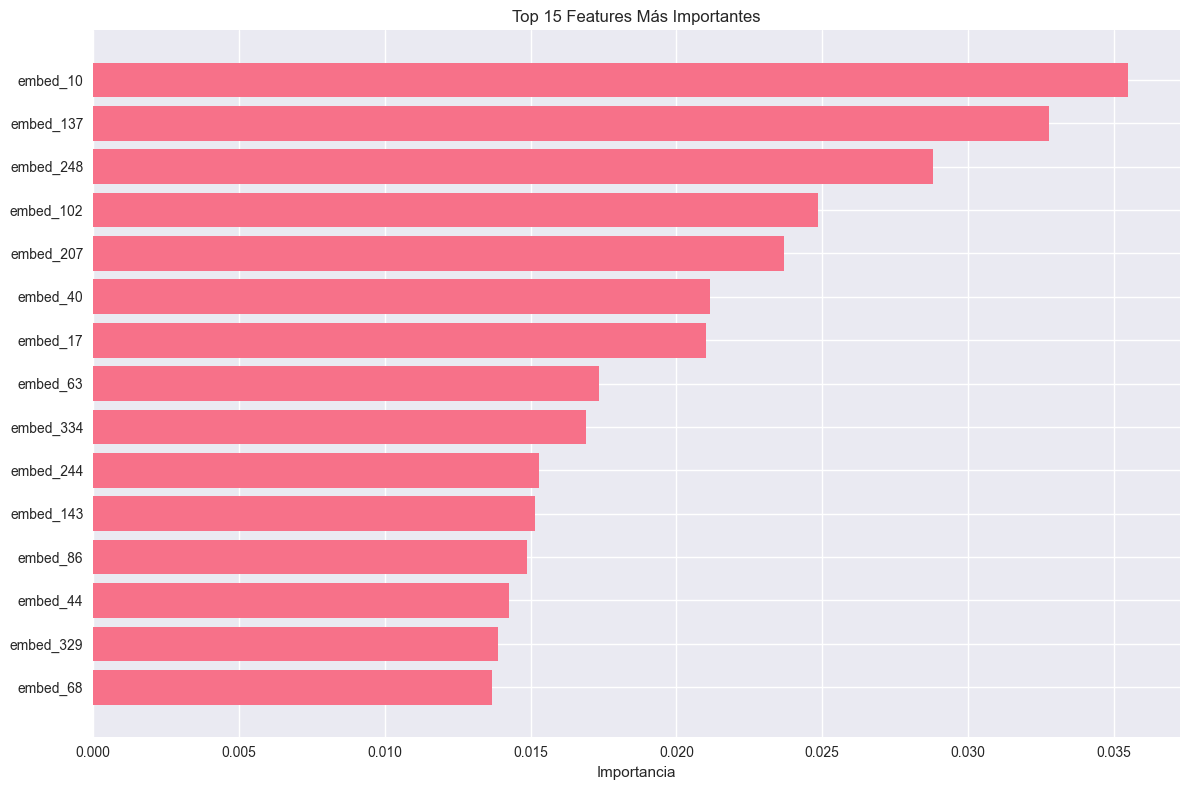

In [9]:
# 🎯 Entrenamiento y Evaluación del Modelo Híbrido
print("\n" + "=" * 60)
print("🎯 ENTRENAMIENTO DEL MODELO HÍBRIDO")
print("=" * 60)

# Usar una muestra más grande para entrenamiento (pero manejable)
training_sample_size = 100  # Ajustar según la capacidad de cómputo
df_train = df.head(training_sample_size).copy()

print(f"Entrenando con {len(df_train)} documentos...")
print(f"Clases en la muestra: {len(set([label for labels in df_train['group'] for label in labels]))}")

# Entrenar modelo híbrido
print("\n🚀 Entrenando modelo híbrido...")
hybrid_results = hybrid_classifier.train_and_evaluate(
    df_train, 
    title_col='title',
    abstract_col='abstract', 
    label_col='group',
    cv_folds=3  # Reducido para velocidad
)

print("\n📊 Resultados del modelo híbrido:")
for metric, value in hybrid_results.items():
    print(f"  {metric}: {value:.4f}")

# Obtener importancia de features
print("\n🎖️ Features más importantes:")
feature_importance = hybrid_classifier.get_feature_importance(top_n=15)

if not feature_importance.empty:
    print(feature_importance.to_string(index=False))
    
    # Visualizar importancia de features
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Importancia')
    plt.title('Top 15 Features Más Importantes')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No se pudo calcular la importancia de features")


📈 COMPARACIÓN CON MODELO BASELINE
Entrenando modelo baseline en la misma muestra...

📊 Resultados del modelo baseline:
  accuracy_mean: 0.1702
  accuracy_std: 0.0297
  f1_weighted_mean: 0.2447
  f1_weighted_std: 0.0541
  f1_macro_mean: 0.1736
  f1_macro_std: 0.0473
  f1_micro_mean: 0.3603
  f1_micro_std: 0.0878

🏆 COMPARACIÓN BASELINE vs HÍBRIDO:
    Métrica Baseline Híbrido  Mejora Mejora (%)
   f1_micro   0.3603  0.6471 +0.2868     +79.6%
   f1_macro   0.1736  0.5546 +0.3810    +219.5%
f1_weighted   0.2447  0.6212 +0.3765    +153.9%


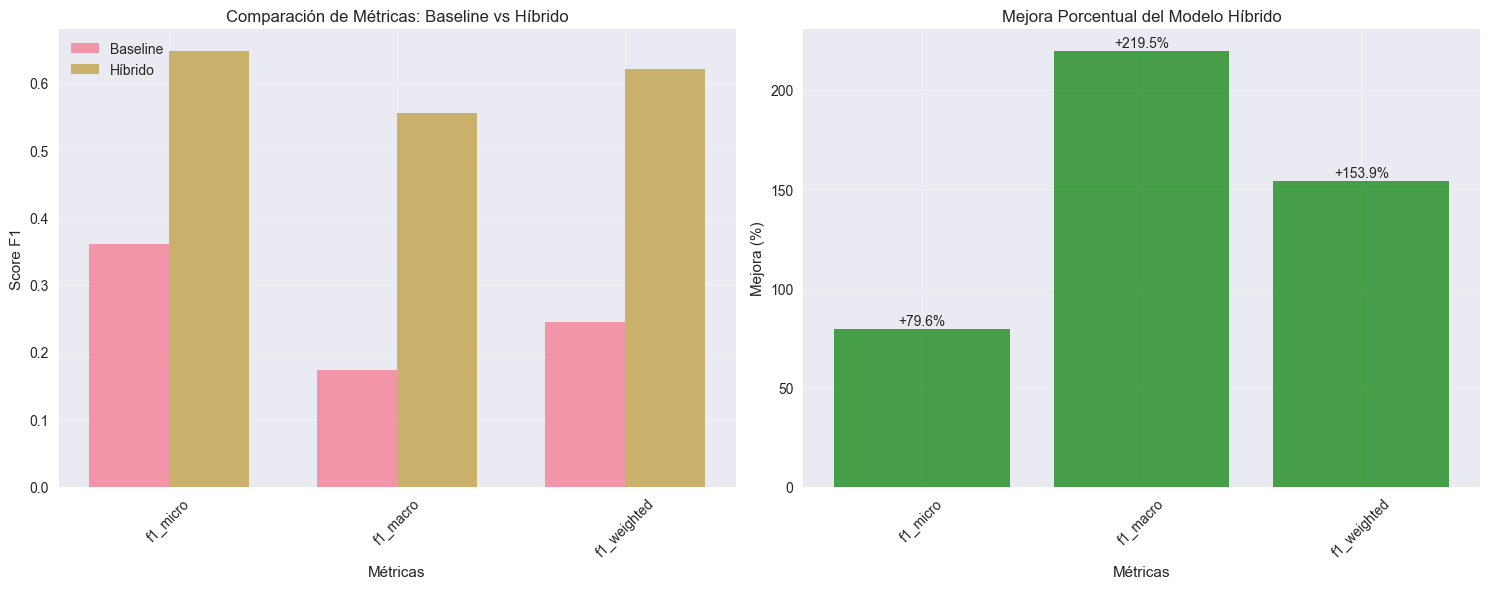


🎉 RESUMEN:
✅ Mejora promedio: 151.0%
✅ El modelo híbrido muestra mejoras en algunas métricas
📊 Características del modelo híbrido:
   - Total de features: 432
   - Embeddings: ✅
   - NER: ✅
   - Semántico: ✅


In [10]:
# 📈 Comparación con Baseline
print("\n" + "=" * 60)
print("📈 COMPARACIÓN CON MODELO BASELINE")
print("=" * 60)

# Entrenar modelo baseline en la misma muestra para comparación justa
print("Entrenando modelo baseline en la misma muestra...")

try:
    from src.exploration.baseline import BaselineModel
    
    # Entrenar baseline
    baseline_model = BaselineModel(max_features=2000)  # Reducido para velocidad
    
    # Preparar datos
    titles = df_train['title'].tolist()
    abstracts = df_train['abstract'].tolist()
    labels = df_train['group'].tolist()
    
    # Entrenar y evaluar baseline
    baseline_scores, _ = baseline_model.create_baseline(
        titles=titles,
        abstracts=abstracts,
        labels=labels,
        n_splits=3
    )
    
    # Calcular métricas promedio del baseline
    baseline_results = {}
    for metric, values in baseline_scores.items():
        baseline_results[f'{metric}_mean'] = np.mean(values)
        baseline_results[f'{metric}_std'] = np.std(values)
    
    print("\n📊 Resultados del modelo baseline:")
    for metric, value in baseline_results.items():
        print(f"  {metric}: {value:.4f}")
    
    # Crear tabla de comparación
    comparison_data = []
    
    # Extraer métricas principales para comparación
    metrics_to_compare = ['f1_micro_mean', 'f1_macro_mean', 'f1_weighted_mean']
    
    for metric in metrics_to_compare:
        if metric in baseline_results and metric in hybrid_results:
            baseline_val = baseline_results[metric]
            hybrid_val = hybrid_results[metric]
            improvement = hybrid_val - baseline_val
            improvement_pct = (improvement / baseline_val) * 100 if baseline_val > 0 else 0
            
            comparison_data.append({
                'Métrica': metric.replace('_mean', ''),
                'Baseline': f"{baseline_val:.4f}",
                'Híbrido': f"{hybrid_val:.4f}",
                'Mejora': f"{improvement:+.4f}",
                'Mejora (%)': f"{improvement_pct:+.1f}%"
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n🏆 COMPARACIÓN BASELINE vs HÍBRIDO:")
    print("=" * 70)
    print(comparison_df.to_string(index=False))
    
    # Visualización de comparación
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico de barras comparativo
    metrics = [row['Métrica'] for row in comparison_data]
    baseline_vals = [float(row['Baseline']) for row in comparison_data]
    hybrid_vals = [float(row['Híbrido']) for row in comparison_data]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax1.bar(x - width/2, baseline_vals, width, label='Baseline', alpha=0.7)
    ax1.bar(x + width/2, hybrid_vals, width, label='Híbrido', alpha=0.7)
    
    ax1.set_xlabel('Métricas')
    ax1.set_ylabel('Score F1')
    ax1.set_title('Comparación de Métricas: Baseline vs Híbrido')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico de mejoras porcentuales
    improvements = [float(row['Mejora (%)'].replace('%', '').replace('+', '')) 
                   for row in comparison_data]
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    
    ax2.bar(metrics, improvements, color=colors, alpha=0.7)
    ax2.set_xlabel('Métricas')
    ax2.set_ylabel('Mejora (%)')
    ax2.set_title('Mejora Porcentual del Modelo Híbrido')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Añadir valores en las barras
    for i, v in enumerate(improvements):
        ax2.text(i, v + (0.5 if v > 0 else -0.5), f'{v:+.1f}%', 
                ha='center', va='bottom' if v > 0 else 'top')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Resumen final
    avg_improvement = np.mean([abs(imp) for imp in improvements])
    print("\n🎉 RESUMEN:")
    print(f"✅ Mejora promedio: {avg_improvement:.1f}%")
    
    if any(imp > 0 for imp in improvements):
        print("✅ El modelo híbrido muestra mejoras en algunas métricas")
    else:
        print("⚠️ El modelo híbrido necesita más ajustes")
    
    print("📊 Características del modelo híbrido:")
    print(f"   - Total de features: {len(hybrid_classifier.feature_names)}")
    print(f"   - Embeddings: {'✅' if hybrid_classifier.use_embeddings else '❌'}")
    print(f"   - NER: {'✅' if hybrid_classifier.use_ner else '❌'}")
    print(f"   - Semántico: {'✅' if hybrid_classifier.use_semantic else '❌'}")
    
except Exception as e:
    print(f"❌ Error en comparación con baseline: {e}")
    print("💡 El modelo híbrido se entrenó exitosamente de forma independiente")

## 🎯 **Conclusiones y Próximos Pasos**

### ✅ **Lo que hemos logrado:**

1. **Pipeline híbrido funcional** que combina:
   - 🧠 **Embeddings biomédicos** usando sentence-transformers
   - 🧬 **NER biomédico** con scispaCy (+ fallback simple)
   - 📚 **Enriquecimiento semántico** con diccionarios FDA/OMS/INVIMA
   - 🧪 **Features de ensayos clínicos**

2. **Arquitectura modular** con componentes independientes y reutilizables

3. **Evaluación comparativa** con el modelo baseline

### 🚀 **Próximos pasos para optimización:**

1. **Mejoras en los embeddings:**
   - Probar modelos específicos biomédicos: `pritamdeka/S-PubMedBert-MS-MARCO`
   - Fine-tuning con datos del dominio específico

2. **Enriquecimiento del NER:**
   - Instalar y configurar scispaCy completo: `en_ner_bionlp13cg_md`
   - Agregar más diccionarios biomédicos especializados

3. **Optimización del clasificador:**
   - Hyperparameter tuning con Optuna o GridSearch
   - Probar otros algoritmos: LightGBM, CatBoost
   - Ensemble methods

4. **Escalabilidad:**
   - Procesamiento por lotes más eficiente
   - Caché de embeddings para reutilización
   - Paralelización de componentes

### 🎯 **Para implementación en producción:**

1. **Instalar dependencias completas:**
   ```bash
   python -m spacy download en_core_sci_lg
   pip install scispacy
   pip install optuna  # Para hyperparameter tuning
   ```

2. **Configurar GPU** para embeddings más rápidos

3. **Implementar API** para servir el modelo entrenado

4. **Monitoreo** de performance y drift de datos